##Importa librerías

In [8]:
# Install libraries
#!pip install boto3
#!pip install emoji
#!pip install mlflow

In [9]:
# Getting the data
import boto3
from google.colab import userdata

# General use
import os
import numpy as np # linear algebra
import pandas as pd # data processing

# Text pre processing
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import emoji

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE #class balance

# Model training and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Experiments workflow
import mlflow
import mlflow.sklearn

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Llaves de AWS
AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID_PROJECT')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY_PROJECT')
AWS_DEFAULT_REGION = 'us-east-2'

s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

# --- Configuración de S3 ---
s3_uri = "s3://s3-cyberbullying-classification-data/files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda"

# Extraemos el bucket y la clave (key) del URI
bucket_name = s3_uri.split('/')[2]
object_key = '/'.join(s3_uri.split('/')[3:])

print(f"Cargando datos desde el bucket: {bucket_name}")
print(f"Clave del objeto: {object_key}")

try:
    # Obtenemos el objeto desde S3
    s3_object = s3.get_object(Bucket=bucket_name, Key=object_key)

    # Leemos el contenido del archivo (asumiendo que es un CSV) en un DataFrame
    # Nota: Si tu archivo es .json, .txt, etc., cambia pd.read_csv por la función adecuada.
    data = pd.read_csv(s3_object['Body'])
    print("\n¡Datos cargados con éxito!")


except Exception as e:
    print(f"Error al cargar los datos: {e}")

Cargando datos desde el bucket: s3-cyberbullying-classification-data
Clave del objeto: files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda

¡Datos cargados con éxito!


##Preprocesamiento y Extracción de Características

In [11]:
data.head(10)# First 10 rows od the dataset

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [12]:
data.drop_duplicates(inplace=True) #Drops duplicates
data.reset_index(drop=True,inplace=True) #Resets index

In [13]:
# Drops ambiguous entries
conflict_mask = (data.groupby('tweet_text')['cyberbullying_type'].transform('nunique') > 1)
data = data[~conflict_mask].reset_index(drop=True)

In [14]:
# Preprocessing
lemmatizer = WordNetLemmatizer() # Creates lemmatizer

def get_wordnet_pos(tag): # Map POS tags to WordNet format
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatizer_words(text): # Creates function to tokenize and lemmatize
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens) #Part-of-speech tag
    lemmatized = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmatized)

data['tweet_text']=data['tweet_text'].astype(str) # Turns object type to string type
data['tweet_text']=data['tweet_text'].apply(lambda text: lemmatizer_words(text)) # Lambda function to lemmatize a specific column

# Creates and combine a list of special stop words
stopwords_especiales = ['rt', 'just', 'don', 'http', 'got', 'https', 'wa', 'amp', 've', 'mkr'] # List of domain-specific stop words
comb_stopwords = list(ENGLISH_STOP_WORDS.union(stopwords_especiales)) #Combine stop words

In [17]:
data.head()

,tweet_text,cyberbullying_type
0,"in other word # katandandre , your food be cra...",not_cyberbullying
1,why be # aussietv so white ? # mkr # theblock ...,not_cyberbullying
2,@ xochitlsuckkks a classy whore ? or more red ...,not_cyberbullying
3,@ rudhoeenglish this be an isi account pretend...,not_cyberbullying
4,"@ raja5aab @ quickieleaks yes , the test of go...",not_cyberbullying


In [18]:
# Encodes labels to integers
data_copy = data.copy()
labels = data['cyberbullying_type']
encoder = LabelEncoder() # Initialize encoder
data_copy.cyberbullying_type = encoder.fit_transform(data_copy.cyberbullying_type)

In [19]:
#Train - test split (avoids data leakage)
x_train, x_test, y_train, y_test = train_test_split(data_copy['tweet_text'], data_copy['cyberbullying_type'], test_size=0.2, random_state=42)

In [20]:
# Defines a function that pre process the data and vectorize it
def vectoriza(data):
    cleaned_docs = []
    for doc in data:
        sin_emojis = emoji.replace_emoji(doc, replace="")
        no_punct = re.sub(r'[^\w\s]', '', sin_emojis)
        no_digits = re.sub(r'\d+', '', no_punct)
        cleaned_docs.append(no_digits)

    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words=comb_stopwords,
        token_pattern=r'(?u)\b\w\w\w+\b'
    )
    vectorizador = tfidf_vectorizer.fit_transform(cleaned_docs)
    return tfidf_vectorizer, vectorizador

vectorizer, x_train_vectorizado = vectoriza(x_train)
print(f"Número de documentos de entrenamiento: {x_train_vectorizado.shape[0]}")

Número de documentos de entrenamiento: 35502


In [21]:
y_train.value_counts() #Checks class balance

,count
cyberbullying_type,
0,6427
5,6393
1,6334
2,6249
3,5090
4,5009


In [22]:
# Class balance with SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)
x_train, y_train = smote.fit_resample(x_train_vectorizado, y_train)
y_train.value_counts()

,count
cyberbullying_type,
1,6427
3,6427
4,6427
2,6427
5,6427
0,6427


##Entrenamiento de Modelo

In [23]:
# Defines mlflow server
#mlflow.set_tracking_uri('databricks')
#experiment = mlflow.set_experiment('/cyberbullying-classification')

In [24]:
# Initialize and train Random Forest Model
rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(x_train, y_train)
# Log the model with MLflow
#mlflow.sklearn.log_model(rf, "random_forest_model")

RandomForestClassifier(n_estimators=30, random_state=42)

##Evaluación de modelo

In [25]:
# Test data preprocessing
def transforma(data, vectorizer):
    cleaned_docs = []
    for doc in data:
        sin_emojis = emoji.replace_emoji(doc, replace="")
        no_punct = re.sub(r'[^\w\s]', '', sin_emojis)
        no_digits = re.sub(r'\d+', '', no_punct)
        cleaned_docs.append(no_digits)

    return vectorizer.transform(cleaned_docs)

x_test_vectorizado = transforma(x_test, vectorizer)
print(f"Forma de matriz de características de prueba: {x_test_vectorizado.shape}")

Forma de matriz de características de prueba: (8876, 5000)


In [26]:
# Evaluate RF model
rf_test_pred = rf.predict(x_test_vectorizado)
print(classification_report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1565
           1       0.98      0.91      0.94      1618
           2       0.90      0.85      0.87      1523
           3       0.62      0.59      0.60      1338
           4       0.57      0.71      0.63      1234
           5       0.95      0.95      0.95      1598

    accuracy                           0.84      8876
   macro avg       0.83      0.83      0.83      8876
weighted avg       0.85      0.84      0.84      8876



In [27]:
# Inverse transform to get original labels
original_labels = encoder.inverse_transform(data_copy['cyberbullying_type'].unique())
print("Original Labels:", original_labels)

Original Labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


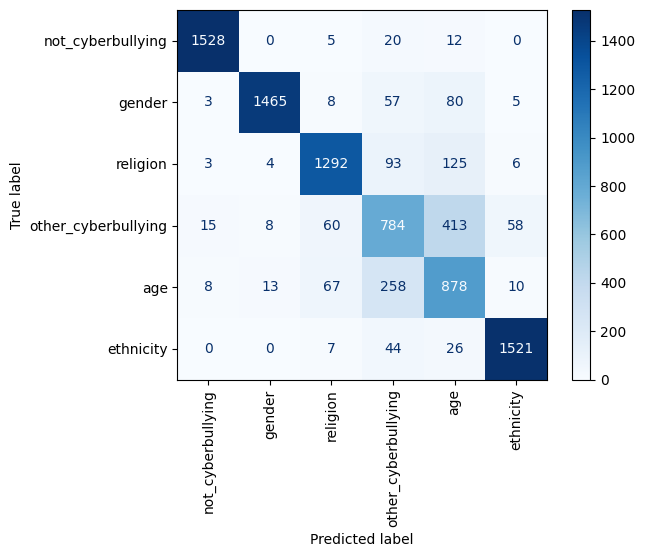

In [28]:
# Confusion matrix of RF model
cm_rf = confusion_matrix(y_test,rf_test_pred)
ConfusionMatrixDisplay(cm_rf, display_labels=original_labels).plot(cmap='Blues', xticks_rotation='vertical')

In [29]:
# Cross validation score
cv_scores_rf = cross_val_score(rf, x_train, y_train, cv=5)

print('Cross validation score (Random Forest Classifier):', cv_scores_rf.mean())

Cross validation score (Random Forest Classifier): 0.8578916112959046
